In [1]:
import os
import numpy as np
import pandas as pd

from pytrack_analysis import Multibench
from pytrack_analysis.dataio import RawData, get_session_list
from pytrack_analysis.profile import get_profile, get_scriptname, show_profile
from pytrack_analysis.posttracking import frameskips, get_displacements, get_head_tail, mistracks, get_pixel_flip
from pytrack_analysis.viz import plot_along, plot_fly, plot_interval, plot_overlay, plot_ts
import matplotlib.pyplot as plt

experiment = 'DIFF'
user = 'degoldschmidt'
ascript = '001-post_tracking.ipynb'

profile = get_profile(experiment, user, script=ascript)
load_from_file = True
folders = profile.get_folders()

E:/Dennis/Google Drive/PhD Project/Tracking Analysis/profile\profile.yaml VERO-PC Windows_NT
System 'VERO-PC' found.
Project 'DIFF' found.


In [3]:
colnames = ['datetime', 'elapsed_time', 'frame_dt', 'body_x',   'body_y',   'angle',    'major',    'minor']
colunits = ['Datetime', 's',            's',        'px',       'px',       'rad',      'px',       'px']
raw_data = RawData(experiment, folders, columns=colnames, units=colunits, noVideo=True)

[pytrack_analysis.dataio]	Loading raw data folders and file structure...found 72 sessionsdone.


In [2]:
raw_data.get_session(0)

[pytrack_analysis.dataio]	Loading raw data folders and file structure...found 72 sessionsdone.
[pytrack_analysis.dataio]	Warning: no video!


0

In [11]:
def plot_arena(arena=None, spots=None, condition=None, ax=None):
    spot_colors = {'yeast': '#ffc04c', 'sucrose': '#4c8bff'}
    cond_colors = {'SAA': '#b6d7a8', 'AA': '#A4C2F4', 'S': '#EA9999', 'O': '#CCCCCC'}
    if ax is None:
        ax = plt.gca()
    ### artists
    if arena is not None:
        ax.set_xlim([-1.1*arena.ro, 1.1*arena.ro])
        ax.set_ylim([-1.1*arena.ro, 1.1*arena.ro])
        arena_border = plt.Circle((0, 0), arena.rr, color='k', fill=False)
        ax.add_artist(arena_border)
        outer_arena_border = plt.Circle((0, 0), arena.ro, color='#aaaaaa', fill=False)
        ax.add_artist(outer_arena_border)
        ax.plot(0, 0, 'o', color='black', markersize=2)
    if spots is not None:
        for each_spot in spots:
            substr = each_spot.substrate
            spot = plt.Circle((each_spot.rx, each_spot.ry), each_spot.rr, color=spot_colors[substr], alpha=0.5)
            ax.add_artist(spot)
    if condition is not None:
        if condition in cond_colors.keys():
            spot = plt.Rectangle((-arena.ro, arena.ro-2), 5, 5, color=cond_colors[condition])
            ax.add_artist(spot)
    ax.set_aspect("equal")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    return ax

In [13]:
def get_session_data(session_id, variables=[]):
    colnames = ['datetime', 'elapsed_time', 'frame_dt', 'body_x',   'body_y',   'angle',    'major',    'minor']
    colunits = ['Datetime', 's',            's',        'px',       'px',       'rad',      'px',       'px']
    session_data = RawData(experiment, session_id, folders, columns=colnames, units=colunits, noVideo=True)
    ### scale trajectories to mm
    scale = 8.543
    session_data.set_scale('fix_scale', scale, unit='mm')
    ### detect frameskips
    frameskips(session_data, dt='frame_dt')
    for i_arena, each_df in enumerate(session_data.raw_data):
        arena = session_data.arenas[i_arena]
        ### compute frame-to-frame displacements
        each_df['displacement'] = get_displacements(each_df, x='body_x', y='body_y')
        ### detect mistracked frames
        each_df = mistracks(each_df, i_arena, dr='displacement', major='major', thresholds=(4, 5), keep=True)
        ### compute head and tail positions
        head_tails = get_head_tail(each_df, x='body_x', y='body_y', angle='angle', major='major')
        each_df['head_x'] = head_tails['head_x']
        each_df['head_y'] = head_tails['head_y']
        each_df['tail_x'] = head_tails['tail_x']
        each_df['tail_y'] = head_tails['tail_y']
        each_df['head_px'] = scale * head_tails['head_x'] + arena.x
        each_df['head_py'] = scale * head_tails['head_y'] + arena.y
        each_df['tail_px'] = scale * head_tails['tail_x'] + arena.x
        each_df['tail_py'] = scale * head_tails['tail_y'] + arena.y
        ### detect head flips
        file_id = 4 * (session_id-1) + i_arena + 1
        _file = os.path.join(folders['processed'],'post_tracking','{}_{:03d}.csv'.format(experiment, file_id))
        if load_from_file:
            df = pd.read_csv(_file, index_col='frame')
            each_df['flip'] = df['flip']
            each_df['headpx'] = df['headpx']
            each_df['tailpx'] = df['tailpx']
        else:
            flip, headpx, tailpx = get_pixel_flip(each_df, hx='head_px', hy='head_py', tx='tail_px', ty='tail_py', video=session_data.video_file, start=session_data.first_frame)
            each_df['flip'] = flip
            each_df['headpx'] = headpx
            each_df['tailpx'] = tailpx
            each_df.to_csv(_file, index_label='frame')
    session_data.flip_y()
    return session_data


Start post-tracking analysis for video session: 01
[pytrack_analysis.dataio]	Timestamp: Friday, 24. November 2017 08:26
[pytrack_analysis.dataio]	Warning: no video!
[pytrack_analysis.dataio]	Loading raw data...done.
[pytrack_analysis.arena]	loading geometry data...done.
[pytrack_analysis.food_spots]	loading food spots data...found a total of 48 spots...done.
[pytrack_analysis.posttracking]	detected frameskips: 17 (0.016% of all frames)
[pytrack_analysis.posttracking]	Arena ↖ - mistracked frames: 0
[pytrack_analysis.posttracking]	Arena ↗ - mistracked frames: 0
[pytrack_analysis.posttracking]	Arena ↙ - mistracked frames: 0
[pytrack_analysis.posttracking]	Arena ↘ - mistracked frames: 0


AttributeError: 'RawData' object has no attribute 'this_cond'

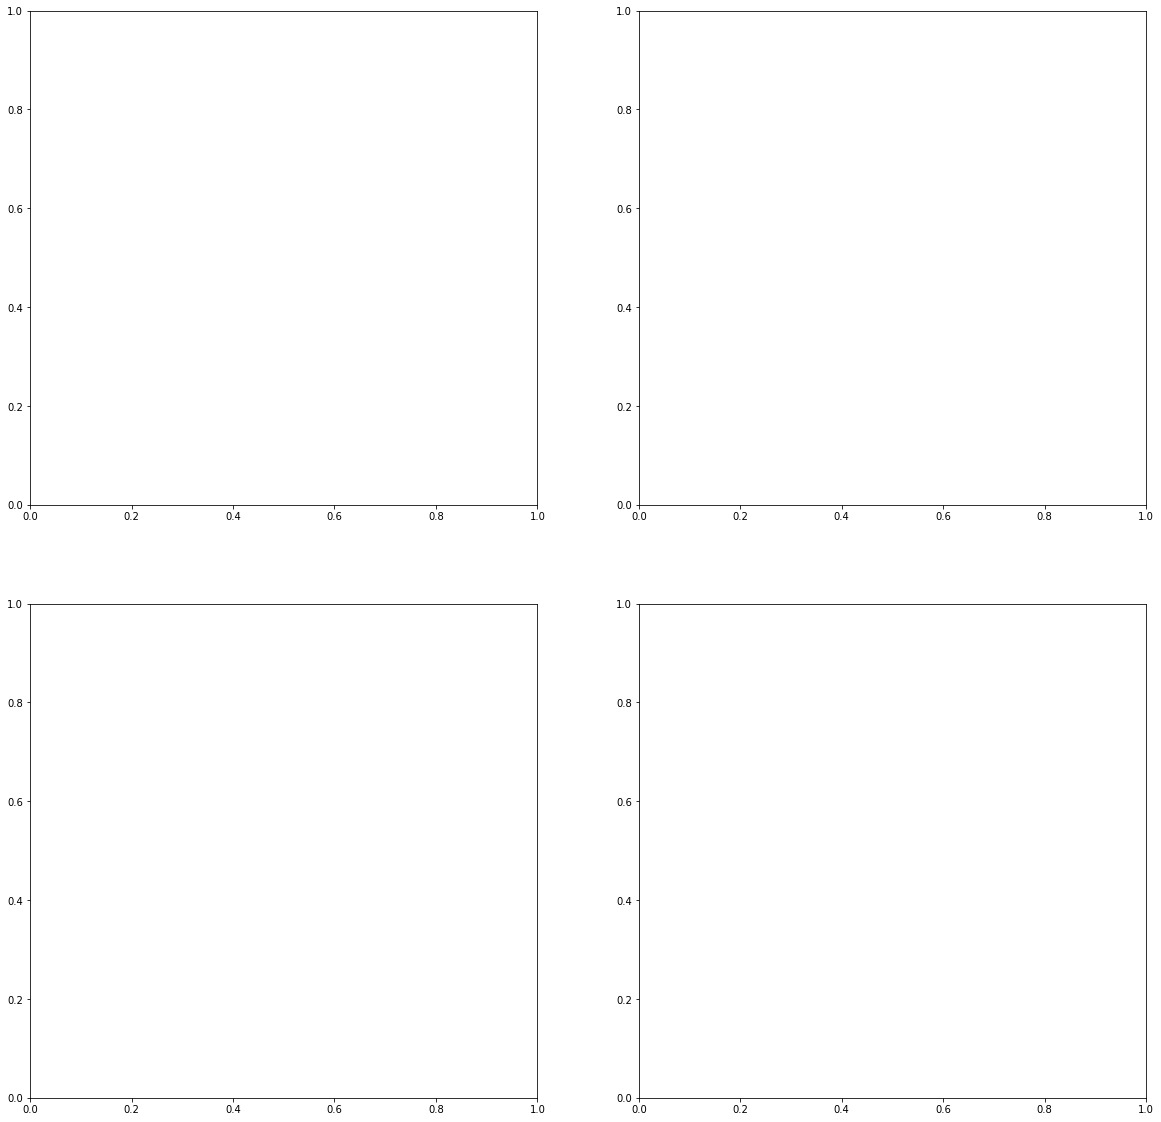

In [15]:
session_data = get_session_data(1, variables='metabolic')
plot_traj(session_data)

In [14]:
def plot_traj(data):
    %matplotlib inline
    f, axes = plt.subplots(2, 2, figsize=(20,20))
    fly = 0
    for each_row in axes:
        for ax in each_row:
            arena = data.arenas[fly]
            df = data.raw_data[fly]
            start, end = df.index[0], df.index[-1]
            ax = plot_arena(arena=arena, spots=arena.spots, condition=data.conditions[fly], ax=ax)
            x = df.loc[start:end, 'body_x']
            y = df.loc[start:end, 'body_y']
            ax.plot(x, y, c='k',)
            fly += 1
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import numpy as np
tmps = [_file[6:-4] for _file in os.listdir('E:/Dennis/Google Drive/PhD Project/Experiments/001-DifferentialDeprivation/data/videos')]
conds = np.loadtxt('E:/Dennis/Google Drive/PhD Project/Experiments/001-DifferentialDeprivation/data/manual/metabolic.txt', skiprows=1, dtype=str)

In [ ]:
for i, each in enumerate(tmps):
    print(each[:-3]+':')
    for j in range(1,5):
        print('- '+conds[i][j])

In [ ]:
print(session_data.allfiles)